# Advent of Code 2015

In recent years I have done [Advent of Code](https://adventofcode.com/2015/) for fun. Drawing inspiration *(and sometimes code)* from the great [Peter Norvig](https://github.com/norvig/pytudes/blob/main/ipynb/Advent-2021.ipynb) I wanted to publish my solution in a similar vein and style as he has done.

Following Norvig's example, each day's work will consist of three tasks, denoted by three bulleted section:

* **Input**: Parse the day's input file. I will use the function `parse(day, parser, sep)`, which:
    - Reads the input file for day.
    - Prints out the first few lines of the file (to remind me, and the notebook reader, what's in the file).
    - Breaks the file into a sequence of entries separated by `sep` (default newline).
    - Applies parser to each entry and returns the results as a tuple.
        - Useful parser functions include `ints`, `digits`, `atoms`, `words`, and the built-ins `int` and `str`.
* **Part 1**: Understand the day's instructions and:
    - Write code to compute the answer to Part 1.
    - Record the answer with the `answer` function, which also serves as a unit test when the notebook is re-run.
* **Part 2**: Understand the second part of the instructions and:
    - Write code and record answer for Part 2.
    
First I import utilities from Norvig along with some others I have found useful.

In [177]:
from collections import Counter, defaultdict, namedtuple, deque
from itertools import permutations, combinations, chain, count as count_from, product as cross_product, groupby, repeat, combinations_with_replacement
from functools import lru_cache, partial
from hashlib import md5
from ast import literal_eval
import json
import queue
import operator
import math
import sys
import re
from statistics import mean, median
from math import ceil, inf, prod
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np

In [178]:
def answer(puzzle_number, got, expected):
    """Verify the answer we got was the expected answer."""
    assert got == expected, f'For {puzzle_number}, expected {expected} but got {got}.'
    return True


def parse(day, parser=str, sep='\n', print_lines=7):
    """Split the day's input file into entries separated by `sep`, and apply `parser` to each and `final` to the result"""
    fname = f'data/2015/input{day}.txt'
    text = open(fname).read()
    entries = mapt(parser, text.rstrip().split(sep))
    if print_lines:
        all_lines = text.splitlines()
        lines = all_lines[:print_lines]
        head = f'{fname} ➜ {len(text)} chars, {len(all_lines)} lines; first {len(lines)} lines:'
        dash = "-" * 100
        print(f'{dash}\n{head}\n{dash}')
        for line in lines:
            print(trunc(line))
        print(f'{dash}\nparse({day}) ➜ {len(entries)} entries:\n'
              f'{dash}\n{trunc(str(entries))}\n{dash}')
    return entries


def trunc(s, left=70, right=25, dots=' ... '):
    """All of string s if it fits; else left and right ends of s with dots in the middle."""
    return s if len(s) <= left + right + len(dots) else s[:left] + dots + s[-right:]

In [179]:
def quantify(iterable, pred=bool):
    """Count the number of items in iterable for which pred is true."""
    return sum(1 for item in iterable if pred(item))


def first(iterable, default=None):
    """Return first item in iterable, or default."""
    return next(iter(iterable), default)


def multimap(items):
    """Given (key, val) pairs, return {key: [val, ....], ...}."""
    result = defaultdict(list)
    for key, val in items:
        result[key].append(val)
    return result


def multidict(items):
    """Given (key1, key2, val) pairs, return {key1: {key2: val, ...}, ...}."""
    result = defaultdict(lambda: defaultdict(lambda: 0))
    for a, b, val in items:
        result[a][b] = val
    return result


def n_times(fn, init, times):
    for _ in range(times):
        init = fn(init)
    return init


def ints(text):
    """Return a tuple of all the integers in text."""
    return mapt(int, re.findall('-?[0-9]+', text))


def digits(text):
    """A tuple of all the digits in text (as ints 0–9), ignoring non-digit characters."""
    return mapt(int, re.findall(r'[0-9]', text))


def atoms(text):
    """A tuple of all the atoms (numbers or symbol names) in text."""
    return mapt(atom, re.findall(r'[a-zA-Z_0-9.+-]+', text))


def atom(text):
    """Parse text into a single float or int or str."""
    try:
        x = float(text)
        return round(x) if round(x) == x else x
    except ValueError:
        return text


def mapt(fn, *args):
    """map(fn, *args) and return the result as a tuple."""
    return tuple(map(fn, *args))


cat = ''.join
flatten = chain.from_iterable

I've included code that scrapes [adventofcode.com](https://adventofcode.com/) for input files. Note that you will have to be logged-in using a browser of your choice.

Your answers will naturally vary from the numbers in my `answer` functions.

In [180]:
import requests
import browser_cookie3
from bs4 import BeautifulSoup
from os.path import isfile

cj = browser_cookie3.firefox()  # Get cookies from currently open browser, could be `.chrome()` or `.brave()`

for day in range(1, 26):
    filename = f"data/2015/input{day}.txt"
    if not isfile(filename):
        r = requests.get(f"https://adventofcode.com/2015/day/{day}/input", cookies=cj)
        open(filename, "w").write(r.text)

# [Day 1](https://adventofcode.com/2015/day/1): Not Quite Lisp

* **Input**: A list where each entry is either an open or closed parenthesis, that is `(`, `)`

In [181]:
in1 = first(parse(1, tuple))

----------------------------------------------------------------------------------------------------
data/2015/input1.txt ➜ 7000 chars, 1 lines; first 1 lines:
----------------------------------------------------------------------------------------------------
(((())))()((((((((())()(()))(()((((()(()(((()((()((()(()()()()()))(((( ... (()))()((((()((()(()()()(
----------------------------------------------------------------------------------------------------
parse(1) ➜ 1 entries:
----------------------------------------------------------------------------------------------------
(('(', '(', '(', '(', ')', ')', ')', ')', '(', ')', '(', '(', '(', '(' ... (', ')', '(', ')', '('),)
----------------------------------------------------------------------------------------------------


* **Part 1**: On which floor does santa end on after going up and down the stairs, as dictated by

In [182]:
stairs = {'(': 1, ')': -1}

In [183]:
def santa_stairs(steps):
    return sum(stairs[s] for s in steps)


assert 0 == santa_stairs("()()") == santa_stairs("))((")
assert 3 == santa_stairs("(()(()(") == santa_stairs("(((") == santa_stairs("))(((((")
assert -1 == santa_stairs("())") == santa_stairs("))(")

answer(1.1, santa_stairs(in1), 232)

True

* **Part 2**: When does santa enter the basement, go below the 0*th* floor?

In [184]:
def when_enter_basement(steps):
    current_floor = 0
    for i, s in enumerate(steps):
        if current_floor < 0:
            return i
        current_floor += stairs[s]


answer(1.2, when_enter_basement(in1), 1783)

True

* **Part 3**: Visualization

Let's take a look at how santa progresses...

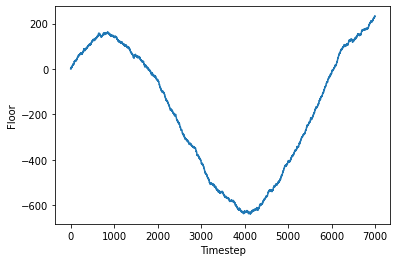

In [185]:
def floor_plan(steps):
    current_floor, floors = 0, []
    for i, s in enumerate(steps):
        current_floor += stairs[s]
        floors.append(current_floor)
    return floors


plt.plot(floor_plan(in1))
plt.ylabel('Floor')
plt.xlabel('Timestep');

We can also use our `floor_plan` function to solve parts one and two. For **Part 1** we simply take the last element, and for **Part 2** we find the index where the value is negative.

In [186]:
answer(1.1, floor_plan(in1)[-1], 232)

True

In [187]:
answer(1.2, 1 + first(step for step, floor in enumerate(floor_plan(in1)) if floor < 0), 1783)

True

# [Day 2](https://adventofcode.com/2015/day/2): I Was Told There Would Be No Math

* **Input**: List of the dimensions (length `l`, width `w`, and height `h`) of each present.

In [188]:
in2 = parse(2, ints)

----------------------------------------------------------------------------------------------------
data/2015/input2.txt ➜ 8121 chars, 1000 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
20x3x11
15x27x5
6x29x7
30x15x9
19x29x21
10x4x15
1x26x4
----------------------------------------------------------------------------------------------------
parse(2) ➜ 1000 entries:
----------------------------------------------------------------------------------------------------
((20, 3, 11), (15, 27, 5), (6, 29, 7), (30, 15, 9), (19, 29, 21), (10, ... (21, 2, 22), (14, 12, 8))
----------------------------------------------------------------------------------------------------


* **Part 1**: Calculate the total surface area needed for the packages along with the area of the smallest side.

In [189]:
def surface_area_with_slack(dimensions):
    l, w, h = sorted(dimensions)
    return 2 * l * w + 2 * w * h + 2 * h * l + l * w


answer(1.1, sum(map(surface_area_with_slack, in2)), 1606483)

True

* **Part 2**: Calculate the total ribbon required for the packages.

The ribbon required to wrap a present is the shortest distance around its sides, or the smallest perimeter of any one face. *Each present also requires a bow made out of ribbon as well; the feet of ribbon required for the perfect bow is equal to the cubic feet of volume of the present. Don't ask how they tie the bow, though; they'll never tell.*

In [190]:
def required_ribbon_and_bow(dimensions):
    l, w, h = sorted(dimensions)
    return 2 * (l + w) + l * w * h

answer(1.2, sum(map(required_ribbon_and_bow, in2)), 3842356)

True

Here are some assertions I used for testing.

In [191]:
assert 43 == surface_area_with_slack((10, 1, 1))
assert 34 == required_ribbon_and_bow((2, 3, 4))
assert 14 == required_ribbon_and_bow((1, 1, 10))

# [Day 3](https://adventofcode.com/2015/day/3): Perfectly Spherical Houses in a Vacuum

* **Input**: A single string containing directions on a 2D map.

In [192]:
in3 = first(parse(3))

----------------------------------------------------------------------------------------------------
data/2015/input3.txt ➜ 8192 chars, 1 lines; first 1 lines:
----------------------------------------------------------------------------------------------------
v>v<vvv<<vv^v<v>vv>v<<<^^^^^<<^<vv>^>v^>^>^>^>^><vvvv<^>^<<^><<<^vvvv> ... >>^><><>v>>v<>^<v^^><<>>>
----------------------------------------------------------------------------------------------------
parse(3) ➜ 1 entries:
----------------------------------------------------------------------------------------------------
('v>v<vvv<<vv^v<v>vv>v<<<^^^^^<<^<vv>^>v^>^>^>^>^><vvvv<^>^<<^><<<^vvv ... ><><>v>>v<>^<v^^><<>>>',)
----------------------------------------------------------------------------------------------------


* **Part 1**: How many houses receive at least one present?

In [193]:
headings = {'>': +1, '<': -1, '^': 1j, 'v': -1j}

def unique_houses(directions):
    santa, received_present = 0, {0}
    for d in directions:
        santa += headings[d]
        received_present.add(santa)
    return len(received_present)

answer(3.1, unique_houses(in3), 2572)

True

* **Part 2**: Now santa has received help from his robot friend. The robot takes every second step in the input while santa takes the rest. How many houses receive at least one present now?

In [194]:
def unique_houses2(directions):
    santa, robot, presents = 0, 0, {0}
    for s, r in zip(directions[0::2], directions[1::2]):
        santa += headings[s]
        robot += headings[r]
        presents |= {santa, robot}
    return len(presents)


answer(3.1, unique_houses2(in3), 2631)

True

Here are some assertions I used for testing.

In [195]:
assert 2 == unique_houses('>')
assert 4 == unique_houses('^>v<')
assert 2 == unique_houses('^v^v^v^v^v')

assert 3 == unique_houses2('^v')
assert 3 == unique_houses2('^>v<')
assert 11 == unique_houses2('^v^v^v^v^v')

# [Day 4](https://adventofcode.com/2015/day/4): The Ideal Stocking Stuffer

* **Input**: Secret key that we need to crack.

In [196]:
in4 = first(parse(4))

----------------------------------------------------------------------------------------------------
data/2015/input4.txt ➜ 9 chars, 1 lines; first 1 lines:
----------------------------------------------------------------------------------------------------
yzbqklnj
----------------------------------------------------------------------------------------------------
parse(4) ➜ 1 entries:
----------------------------------------------------------------------------------------------------
('yzbqklnj',)
----------------------------------------------------------------------------------------------------


* **Part 1**: A single string, that is the secret key we have to *crack*, that is find a hexadecimal MD5 hash that starts with at least five zeroes.

In [197]:
def crack_secret_key(key, zeros=5):
    for num in range(10_000_000):
        hashed = md5(f'{key}{num}'.encode()).hexdigest()
        if hashed[:zeros] == '0' * zeros:
            return num


answer(4.1, crack_secret_key(in4), 282_749)

True

* **Part 2**: Find a hexadecimal MD5 hash that starts with at least **six** zeroes.

In [198]:
answer(4.2, crack_secret_key(in4, zeros=6), 9_962_624)

True

Some tests.

In [199]:
assert 609_043 == crack_secret_key('abcdef')
assert 1_048_970 == crack_secret_key('pqrstuv')


# [Day 5](https://adventofcode.com/2015/day/5): Doesn't He Have Intern-Elves For This?

* **Input**: A list of strings.

In [200]:
in5 = parse(5)

----------------------------------------------------------------------------------------------------
data/2015/input5.txt ➜ 17000 chars, 1000 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
uxcplgxnkwbdwhrp
suerykeptdsutidb
dmrtgdkaimrrwmej
ztxhjwllrckhakut
gdnzurjbbwmgayrg
gjdzbtrcxwprtery
fbuqqaatackrvemm
----------------------------------------------------------------------------------------------------
parse(5) ➜ 1000 entries:
----------------------------------------------------------------------------------------------------
('uxcplgxnkwbdwhrp', 'suerykeptdsutidb', 'dmrtgdkaimrrwmej', 'ztxhjwll ... kkf', 'wtebigbaythklkbd')
----------------------------------------------------------------------------------------------------


* **Part 1**: Determine how many strings are **nice**:
    - It contains at least three vowels (`aeiou` only), like `aei`, `xazegov`, or `aeiouaeiouaeiou`.
    - It contains at least one letter that appears twice in a row, like `xx`, `abcdde` (`dd`), or `aabbccdd` (`aa`, `bb`, `cc`, or `dd`).
    - It does not contain the strings `ab`, `cd`, `pq`, or `xy`, even if they are part of one of the other requirements.

In [201]:
def is_nice(string):
    return any(s1 == s2 for s1, s2 in zip(string[:-1], string[1:])) and \
           quantify(s in 'aeiou' for s in string) >= 3 and \
           not any(s in string for s in ('ab', 'cd', 'pq', 'xy'))


answer(5.1, quantify(map(is_nice, in5)), 236)

True

* **Part 2**: The definition of a **nice** string has changed:
    - It contains a pair of any two letters that appears at least twice in the string without overlapping, like `xyxy` (`xy`) or `aabcdefgaa` (`aa`), but not like `aaa` (`aa`, but it overlaps).
    - It contains at least one letter which repeats with exactly one letter between them, like `xyx`, `abcdefeghi` (`efe`), or even `aaa`.

In [202]:
def is_nice2(string):
    return any(string[i:i + 2] in string[i + 2:] for i in range(len(string) - 3)) and \
           any(a == c for a, c in zip(string, string[2:]))


answer(5.2, quantify(map(is_nice2, in5)), 51)

True

Some assertions..

In [203]:
assert True == all(is_nice(s) for s in ('ugknbfddgicrmopn', 'aaa'))
assert False == any(is_nice(s) for s in ('jchzalrnumimnmhp', 'haegwjzuvuyypxyu', 'dvszwmarrgswjxmb'))

assert True  == all(is_nice2(s) for s in ('qjhvhtzxzqqjkmpb', 'xxyxx'))
assert False == any(is_nice2(s) for s in ('uurcxstgmygtbstg', 'ieodomkazucvgmuy', 'ugknbfddgicrmopn', 'aaa',
                                          'jchzalrnumimnmhp', 'haegwjzuvuyypxyu', 'dvszwmarrgswjxmb'))


# [Day 6](https://adventofcode.com/2015/day/6): Probably a Fire Hazard

* **Input**: List of instructions like *turn on*, *turn off* and *toggle* to be executed on a 1000x1000 grid of lights.

In [204]:
def parse_lights(line):
    return tuple(elem for elem in atoms(line) if elem not in ('turn', 'through'))

in6 = parse(6, parse_lights)

----------------------------------------------------------------------------------------------------
data/2015/input6.txt ➜ 9531 chars, 300 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
turn on 887,9 through 959,629
turn on 454,398 through 844,448
turn off 539,243 through 559,965
turn off 370,819 through 676,868
turn off 145,40 through 370,997
turn off 301,3 through 808,453
turn on 351,678 through 951,908
----------------------------------------------------------------------------------------------------
parse(6) ➜ 300 entries:
----------------------------------------------------------------------------------------------------
(('on', 887, 9, 959, 629), ('on', 454, 398, 844, 448), ('off', 539, 24 ... ff', 102, 229, 674, 529))
----------------------------------------------------------------------------------------------------


* **Part 1**: How many lights are lit after running the instructions?

In [205]:
def execute(instructions, ops, grid=1000):
    lights = [[False] * grid for _ in range(grid)]
    for op, x0, y0, x1, y1 in instructions:
        for x, y in ((x, y) for x in range(x0, x1 + 1) for y in range(y0, y1 + 1)):
            lights[x][y] = ops[op](lights[x][y])
    return sum(flatten(lights))


fuel_needed = {
    'toggle': lambda x: int(not x == 1),
    'on': lambda _: 1,
    'off': lambda _: 0,
}

answer(6.1, execute(in6, fuel_needed), 377_891)

True

* **Part 2**: Meaning of *turn on/off* and *toggle* changed to mean *brightness* instead of discrete values. How many lights are now lit?

In [206]:
fuel_needed2 = {
    'toggle': lambda x: x + 2,
    'on': lambda x: x + 1,
    'off': lambda x: max(x - 1, 0),
}

answer(6.2, execute(in6, fuel_needed2), 14_110_788)

True

# [Day 7](https://adventofcode.com/2015/day/7): Some Assembly Required

* **Input**: List of connections between bitwise logic gates. I will parse these as a dictionary, with the destination wire as key.

In [207]:
def parser(line):
    tokens = atoms(line)
    return tokens[-1], tokens[:-2]

in7 = dict(parse(7, parser))

----------------------------------------------------------------------------------------------------
data/2015/input7.txt ➜ 5304 chars, 339 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
lf AND lq -> ls
iu RSHIFT 1 -> jn
bo OR bu -> bv
gj RSHIFT 1 -> hc
et RSHIFT 2 -> eu
bv AND bx -> by
is OR it -> iu
----------------------------------------------------------------------------------------------------
parse(7) ➜ 339 entries:
----------------------------------------------------------------------------------------------------
(('ls', ('lf', 'AND', 'lq')), ('jn', ('iu', 'RSHIFT', 1)), ('bv', ('bo ... h', ('he', 'RSHIFT', 5)))
----------------------------------------------------------------------------------------------------


* **Part 1**: We want to find the value on the `a` wire. My strategy was to recursively go through the circuit to try and find an actual `int` value on the wire. We can use memoization on the values that we have already found.

In [208]:
@lru_cache()
def get_value(key):
    try:
        return int(key)
    except ValueError:
        pass

    cmd = in7[key]

    if "NOT" in cmd:
        return ~get_value(cmd[1])
    elif "AND" in cmd:
        return get_value(cmd[0]) & get_value(cmd[2])
    elif "OR" in cmd:
        return get_value(cmd[0]) | get_value(cmd[2])
    elif "LSHIFT" in cmd:
        return get_value(cmd[0]) << get_value(cmd[2])
    elif "RSHIFT" in cmd:
        return get_value(cmd[0]) >> get_value(cmd[2])
    else:
        return get_value(cmd[0])


answer(7.1, get_value('a'), 16076)

True

* **Part 2**: Now, take the signal you got on wire `a`, override wire `b` to that signal, and reset the other wires (including wire `a`). What new signal is ultimately provided to wire `a`?

In [209]:
in7['b'] = str(get_value('a'))
get_value.cache_clear()
answer(7.2, get_value('a'), 32790)

True

# [Day 8](https://adventofcode.com/2015/day/8): Matchsticks

* **Input**: List of strings with escape special characters.

In [210]:
in8 = parse(8)

----------------------------------------------------------------------------------------------------
data/2015/input8.txt ➜ 6610 chars, 300 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
"sjdivfriyaaqa\xd2v\"k\"mpcu\"yyu\"en"
"vcqc"
"zbcwgmbpijcxu\"yins\"sfxn"
"yumngprx"
"bbdj"
"czbggabkzo\"wsnw\"voklp\"s"
"acwt"
----------------------------------------------------------------------------------------------------
parse(8) ➜ 300 entries:
----------------------------------------------------------------------------------------------------
('"sjdivfriyaaqa\\xd2v\\"k\\"mpcu\\"yyu\\"en"', '"vcqc"', '"zbcwgmbpij ... ycnh"', '"lltj\\"kbbxi"')
----------------------------------------------------------------------------------------------------


* **Part 1**: What is the number of characters of code for string literals minus the number of characters in memory for the values of the strings.We can get the first one by finding the `len` of each line and the second by using [`eval`](https://docs.python.org/3/library/functions.html#eval) to *remove* the escaped strings.

In [211]:
answer(8.1, sum(len(line) - len(eval(line)) for line in in8), 1333)

True

* **Part 2**: Here we need to go the over way round, namely find the total number of characters to represent the newly encoded strings minus the number of characters of code in each original string literal. Here we can realize that the difference are two `\` at the beginning of the string, and we need `\` for each `"` and `\` we find too.

In [212]:
answer(8.1, sum(line.count('"') + line.count('\\') + 2 for line in in8), 2046)

True

Some assertions for testing out `eval`.

In [213]:
assert len(eval('""')) == 0
assert len(eval('"abc"')) == 3
assert len(eval('"\x27"')) == 1

# [Day 9](https://adventofcode.com/2015/day/9): All in a Single Night

* **Input**: List of distances between a pair of cities. We will store these in a `multidict` where the distance is stored for both cities.

In [214]:
def parse_path(line):
    city1, _, city2, distance = atoms(line)
    return city1, city2, distance

def multidict2(items):
    """Given (key1, key2, val) pairs, return {key1: {key2: val, ...}, key2: {key1: val, ...} ...}."""
    result = defaultdict(lambda: defaultdict(lambda: 0))
    for a, b, val in items:
        result[a][b] = result[b][a] = val
    return result

in9 = distances = multidict2(parse(9, parse_path))

----------------------------------------------------------------------------------------------------
data/2015/input9.txt ➜ 715 chars, 28 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
Faerun to Norrath = 129
Faerun to Tristram = 58
Faerun to AlphaCentauri = 13
Faerun to Arbre = 24
Faerun to Snowdin = 60
Faerun to Tambi = 71
Faerun to Straylight = 67
----------------------------------------------------------------------------------------------------
parse(9) ➜ 28 entries:
----------------------------------------------------------------------------------------------------
(('Faerun', 'Norrath', 129), ('Faerun', 'Tristram', 58), ('Faerun', 'A ... ambi', 'Straylight', 70))
----------------------------------------------------------------------------------------------------


* **Part 1**: We are asked to find the shortest distance between all cities. This is an example of a [travelling salesman problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem). Fortunately we only have eight cities so we can just try all possibilities.

In [215]:
def all_paths(distances):
    return (sum(distances[p1][p2] for p1, p2 in zip(p[:-1], p[1:])) for p in permutations(distances.keys()))

In [216]:
answer(9.1, min(all_paths(in9)), 207)

True

* **Part 2**: What is the longest path?

In [217]:
answer(9.2, max(all_paths(in9)), 804)

True

# [Day 10](https://adventofcode.com/2015/day/10): Elves Look, Elves Say

* **Input**: A string that is the beginning of a [look-and-say](https://en.wikipedia.org/wiki/Look-and-say_sequence) sequence.

In [218]:
in10 = first(parse(10))

----------------------------------------------------------------------------------------------------
data/2015/input10.txt ➜ 11 chars, 1 lines; first 1 lines:
----------------------------------------------------------------------------------------------------
1113222113
----------------------------------------------------------------------------------------------------
parse(10) ➜ 1 entries:
----------------------------------------------------------------------------------------------------
('1113222113',)
----------------------------------------------------------------------------------------------------


* **Part 1**: What is the length of a sequence after applying the *look-and-say* process 40 times?

In [219]:
def repeat_and_say(word):
    return cat(f'{quantify(count)}{letter}' for letter, count in groupby(word))


answer(10.1, len(n_times(repeat_and_say, in10, 40)), 252_594)

True

* **Part 2**: What about 50 times?

In [220]:
answer(10.2, len(n_times(repeat_and_say, in10, 50)), 3_579_328)

True

# [Day 11](https://adventofcode.com/2015/day/11): Corporate Policy

* **Input**: Santa's old password (string)

In [221]:
in11 = first(parse(11))

----------------------------------------------------------------------------------------------------
data/2015/input11.txt ➜ 9 chars, 1 lines; first 1 lines:
----------------------------------------------------------------------------------------------------
vzbxkghb
----------------------------------------------------------------------------------------------------
parse(11) ➜ 1 entries:
----------------------------------------------------------------------------------------------------
('vzbxkghb',)
----------------------------------------------------------------------------------------------------


* **Part 1**: We want to find a new password for santa. he finds his new password by incrementing his old password string repeatedly until it is valid. The new password should meet the following criteria:
   - Passwords must include one increasing straight of at least three letters, like `abc`, `bcd`, `cde`, and so on, up to `xyz`. They cannot skip letters; `abd` doesn't count.
   - Passwords may not contain the letters `i`, `o`, or `l`, as these letters can be mistaken for other characters and are therefore confusing.
   - Passwords must contain at least two different, non-overlapping pairs of letters, like `aa`, `bb`, or `zz`.
- We need to use built-in functions [`ord`](https://docs.python.org/3/library/functions.html#ord) and [`chr`](https://docs.python.org/3/library/functions.html#chr) for the position of the letters.


In [222]:
@lru_cache()
def is_valid(password):
    num = mapt(ord, password)
    has_increasing_subsequence = any(num[i] + 2 == num[i + 1] + 1 == num[i + 2] for i in range(len(num) - 2))
    does_not_contain_iol = not any(c in password for c in 'iol')
    has_two_diff_pairs = len(set(re.findall(r'(.)\1', password))) >= 2
    return has_increasing_subsequence and does_not_contain_iol and has_two_diff_pairs


@lru_cache()
def increment(password):
    numeric, index = list(map(ord, password)), -1
    while True:
        numeric[index] += 1
        if numeric[index] <= ord('z'):
            break
        else:
            numeric[index] = ord('a')
            index -= 1
    return cat(map(chr, numeric))


def next_valid(pw):
    return first(pw for _ in repeat(0) if is_valid(pw := increment(pw)))


answer(11.1, next_valid(in11), 'vzbxxyzz')

True

* **Part 2**: Santa's password expired again. What's the next one?

In [223]:
answer(11.2, n_times(next_valid, in11, 2), 'vzcaabcc')

True

# [Day 12](https://adventofcode.com/2015/day/12): JSAbacusFramework.io

* **Input**: String in the form of a `JSON`. I will use the built-in function [`json.loads`](https://docs.python.org/3/library/json.html) to decode the string into a `JSON` data structure.

In [224]:
in12 = json.loads(first(parse(12)))

----------------------------------------------------------------------------------------------------
data/2015/input12.txt ➜ 37048 chars, 1 lines; first 1 lines:
----------------------------------------------------------------------------------------------------
[{"a":{"e":{"e":161,"a":"blue","d":{"e":-14,"a":"red","d":{"c":"yellow ... ,-23],"g":199,"f":76}]]]]
----------------------------------------------------------------------------------------------------
parse(12) ➜ 1 entries:
----------------------------------------------------------------------------------------------------
('[{"a":{"e":{"e":161,"a":"blue","d":{"e":-14,"a":"red","d":{"c":"yell ... 3],"g":199,"f":76}]]]]',)
----------------------------------------------------------------------------------------------------


* **Part 1**: Sum all the numbers in the `JSON` object.

In [225]:
def sum_numbers(js):
    return sum(map(sum_numbers, js.values()) if isinstance(js, dict) else
               map(sum_numbers, js) if isinstance(js, list) else
               (js,) if isinstance(js, int) else (0,))


answer(12.1, sum_numbers(in12), 156_366)

True

* **Part 2**: Sum all the numbers in the `JSON` object, excluding objects where the string "red" appears.

In [226]:
def sum_numbers2(js):
    return sum(map(sum_numbers2, (0,) if 'red' in js.values() else js.values()) if isinstance(js, dict) else
               map(sum_numbers2, js) if isinstance(js, list) else
               (js,) if isinstance(js, int) else (0,))


answer(12.2, sum_numbers2(in12), 96_852)

True

# [Day 13](https://adventofcode.com/2015/day/13): Knights of the Dinner Table

* **Input**: List of strings containing information about losing/gaining happiness with two people sitting next to each other. I'll parse this into a `multidict`.

In [227]:
def parse_happiness(line):
    a, gain, amount, b = re.match(r'(\w+) would (\w+) (\d+) happiness units by sitting next to (\w+).', line).groups()
    return a, b, -int(amount) if gain == 'lose' else int(amount)


seating = in13 = multidict(parse(13, parse_happiness))

----------------------------------------------------------------------------------------------------
data/2015/input13.txt ➜ 3465 chars, 56 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
Alice would lose 2 happiness units by sitting next to Bob.
Alice would lose 62 happiness units by sitting next to Carol.
Alice would gain 65 happiness units by sitting next to David.
Alice would gain 21 happiness units by sitting next to Eric.
Alice would lose 81 happiness units by sitting next to Frank.
Alice would lose 4 happiness units by sitting next to George.
Alice would lose 80 happiness units by sitting next to Mallory.
----------------------------------------------------------------------------------------------------
parse(13) ➜ 56 entries:
----------------------------------------------------------------------------------------------------
(('Alice', 'Bob', -2), ('Alice', 'Carol', -62), ('Alice', 'David', 65) ... Mall

* **Part 1**: Find the happiness level.


In [228]:
def happiness(order):
    return sum(seating[a][b] + seating[b][a] for a, b in zip(order, order[1:] + (order[0],)))


answer(13.1, max(happiness(order) for order in permutations(seating.keys())), 664)

True

* **Part 2**: Find the happiness level, with `myself` included.

In [229]:
answer(13.1, max(happiness(order) for order in permutations(tuple(seating.keys()) + ('me', ))), 640)

True

# [Day 14](https://adventofcode.com/2015/day/14): Reindeer Olympics

* **Input**: List of strings containing reindeer and some stats like their *speed*, *flying* and *resting time*. I'll parse these into a `dict`.

In [230]:
def parse_reindeer(line):
    name, speed, time, _, rest = re.match(r'(\w+) can fly (\d+) km/s for (\d+) (.*) (\d+) seconds.', line).groups()
    return name, {
        'speed': int(speed),
        'flying_time': int(time),
        'resting_time': int(rest),
        'distance': 0,
        'resting': False,
        'timer': int(time),
        'score': 0
    }


in14 = dict(parse(14, parse_reindeer))

----------------------------------------------------------------------------------------------------
data/2015/input14.txt ➜ 656 chars, 9 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
Vixen can fly 8 km/s for 8 seconds, but then must rest for 53 seconds.
Blitzen can fly 13 km/s for 4 seconds, but then must rest for 49 seconds.
Rudolph can fly 20 km/s for 7 seconds, but then must rest for 132 seconds.
Cupid can fly 12 km/s for 4 seconds, but then must rest for 43 seconds.
Donner can fly 9 km/s for 5 seconds, but then must rest for 38 seconds.
Dasher can fly 10 km/s for 4 seconds, but then must rest for 37 seconds.
Comet can fly 3 km/s for 37 seconds, but then must rest for 76 seconds.
----------------------------------------------------------------------------------------------------
parse(14) ➜ 9 entries:
----------------------------------------------------------------------------------------------------
(('Vi

* **Part 1**: Simulate how the reindeer will progress. Find the maximum distance a single reindeer has travelled.

In [231]:
def simulate(reindeers, simulation_time=2503):
    for _ in range(simulation_time):
        for reindeer in reindeers.values():
            if reindeer['timer'] == 0:
                reindeer['resting'] = not reindeer['resting']
                reindeer['timer'] = reindeer['resting_time' if reindeer['resting'] else 'flying_time']

            reindeer['distance'] += reindeer['speed'] if not reindeer['resting'] else 0
            reindeer['timer'] -= 1

        for reindeer in reindeers.values():
            reindeer['score'] += reindeer['distance'] == max(reindeer['distance'] for reindeer in reindeers.values())

    return reindeers


reindeers = simulate(in14)

In [232]:
answer(14.1, max(reindeer['distance'] for reindeer in reindeers.values()), 2655)

True

* **Part 2**: Find the maximum total *score*. One point is awarded to the reindeer who has travelled the max distance each step.

In [233]:
answer(14.2, max(reindeer['score'] for reindeer in reindeers.values()), 1059)

True

# [Day 15](https://adventofcode.com/2015/day/15): Science for Hungry People

* **Input**: List of strings containing information about ingredients like their *name*, *flavor* and *texture*. I'll parse these into a `dict`

In [234]:
def parse_ingredients(line):
    name, _, c, _, d, _, f, _, t, _, cal = atoms(line)
    return name, {'capacity': c, 'durability': d, 'flavor': f, 'texture': t, 'calories': cal}


ingredients = in15 = dict(parse(15, parse_ingredients))

----------------------------------------------------------------------------------------------------
data/2015/input15.txt ➜ 278 chars, 4 lines; first 4 lines:
----------------------------------------------------------------------------------------------------
Sprinkles: capacity 5, durability -1, flavor 0, texture 0, calories 5
PeanutButter: capacity -1, durability 3, flavor 0, texture 0, calories 1
Frosting: capacity 0, durability -1, flavor 4, texture 0, calories 6
Sugar: capacity -1, durability 0, flavor 0, texture 2, calories 8
----------------------------------------------------------------------------------------------------
parse(15) ➜ 4 entries:
----------------------------------------------------------------------------------------------------
(('Sprinkles', {'capacity': 5, 'durability': -1, 'flavor': 0, 'texture ... ure': 2, 'calories': 8}))
----------------------------------------------------------------------------------------------------


* **Part 1**: Find the best score, namely the one that maximizes the attributes an ingredient has.

In [235]:
def cookie(ingredients, max_calories=None):
    best_score = 0
    for potential_ingredients in combinations_with_replacement(ingredients.values(), 100):
        capacity = sum(ingredient['capacity'] for ingredient in potential_ingredients)
        durability = sum(ingredient['durability'] for ingredient in potential_ingredients)
        flavor = sum(ingredient['flavor'] for ingredient in potential_ingredients)
        texture = sum(ingredient['texture'] for ingredient in potential_ingredients)
        calories = sum(ingredient['calories'] for ingredient in potential_ingredients)

        score = max(0, capacity) * max(0, durability) * max(0, flavor) * max(0, texture)
        best_score = max(best_score, score if max_calories is None or calories == max_calories else 0)
    return best_score


answer(15.1, cookie(ingredients), 13_882_464)

True

* **Part 2**: The number of calories must be 500. Find the best score again.

In [236]:
answer(15.2, cookie(ingredients, max_calories=500), 11_171_160)

True

# [Day 16](https://adventofcode.com/2015/day/16): Aunt Sue

* **Input**: List of *Sues* with number of gifts. Let's parse these into a `dict` of `dict`.

In [237]:
def parse_sue(line):
    _, sue, t1, n1, t2, n2, t3, n3 = atoms(line)
    return int(sue), {t1: int(n1), t2: int(n2), t3: int(n3)}


sues = in16 = dict(parse(16, parse_sue))

----------------------------------------------------------------------------------------------------
data/2015/input16.txt ➜ 21573 chars, 500 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
Sue 1: goldfish: 6, trees: 9, akitas: 0
Sue 2: goldfish: 7, trees: 1, akitas: 0
Sue 3: cars: 10, akitas: 6, perfumes: 7
Sue 4: perfumes: 2, vizslas: 0, cars: 6
Sue 5: goldfish: 1, trees: 3, perfumes: 10
Sue 6: children: 9, vizslas: 7, cars: 9
Sue 7: cars: 6, vizslas: 5, cats: 3
----------------------------------------------------------------------------------------------------
parse(16) ➜ 500 entries:
----------------------------------------------------------------------------------------------------
((1, {'goldfish': 6, 'trees': 9, 'akitas': 0}), (2, {'goldfish': 7, 't ...  'cars': 9, 'trees': 4}))
----------------------------------------------------------------------------------------------------


* **Part 1**: Find the number of the Sue that gave you the presents.


In [238]:
def which_sue(sues):
    equals = {'children': 3, 'cats': 7, 'samoyeds': 2, 'pomeranians': 3, 'akitas': 0,
              'vizslas': 0, 'goldfish': 5, 'trees': 3, 'cars': 2, 'perfumes': 1}
    return first(sue for sue, presents in sues.items()
                 if all(item in equals.items() for item in presents.items()))


answer(16.2, which_sue(sues), 103)

True

* **Part 2**: Find the number of the Sue that gave you the presents with updated terms.

In [239]:
def which_sue2(sues):
    equals = {'children': 3, 'samoyeds': 2, 'akitas': 0, 'vizslas': 0, 'cars': 2, 'perfumes': 1}
    greater, less = {'trees': 3, 'cats': 7}, {'pomeranians': 3, 'goldfish': 5}
    return first(sue for sue, presents in sues.items()
                 if all(val > greater[key] if key in greater else
                        val < less[key] if key in less else
                        val == equals[key]
                        for key, val in presents.items()))

answer(16.2, which_sue2(sues), 405)

True

# [Day 17](https://adventofcode.com/2015/day/17): No Such Thing as Too Much

* **Input**: List of container sizes.

In [240]:
containers = in17 = parse(17, int)

----------------------------------------------------------------------------------------------------
data/2015/input17.txt ➜ 59 chars, 20 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
50
44
11
49
42
46
18
----------------------------------------------------------------------------------------------------
parse(17) ➜ 20 entries:
----------------------------------------------------------------------------------------------------
(50, 44, 11, 49, 42, 46, 18, 32, 26, 40, 21, 7, 18, 43, 10, 47, 36, 24, 22, 40)
----------------------------------------------------------------------------------------------------


* **Part 1**: How many combinations of containers can exactly fit all 150 liters of eggnog.

In [241]:
def combinations_of(containers, total=150):
    return (y for x in range(len(containers))
              for y in combinations(containers, x)
              if sum(y) == total)


answer(17.1, quantify(combinations_of(containers)), 654)

True

* **Part 2**: We want to find the minimum number of containers that can exactly fit all 150 liters of eggnog. How many ways can you fill that number of containers and still hold exactly 150 litres?

In [242]:
min_len = min(map(len, combinations_of(containers)))
answer(17.2, quantify(combinations_of(containers), lambda comb: min_len == len(comb)), 57)

True

# [Day 18](https://adventofcode.com/2015/day/18): Like a GIF For Your Yard

* **Input**: 100x100 grid of lights where a `#` means "on", and a `.` means "off". I'll parse those into a set containing lights that are lit.

In [243]:
with open('data/2015/input18.txt') as f:
    lights = in18 = {(x, y) for y, line in enumerate(f) for x, char in enumerate(line) if char == '#'}

* **Part 1**: This is [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) in disguise. All we need to do is run the simulation 100 times.

In [244]:
def run_lights(lights, corners, steps=100, size=100):
    lights = corners | lights
    for _ in range(steps):
        lights = corners | {(x, y) for x in range(size) for y in range(size)
                         if (x, y) in lights and 2 <= neighbours(lights, x, y) <= 3
                         or (x, y) not in lights and neighbours(lights, x, y) == 3}
    return lights


def neighbours(lights, x, y):
    return sum((xx, yy) in lights
               for xx in (x - 1, x, x + 1)
               for yy in (y - 1, y, y + 1)
               if (xx, yy) != (x, y))

In [245]:
answer(18.1, len(run_lights(lights, corners=set())), 821)

True

* **Part 2**: Now we add corners that are **always lit**.

In [246]:
answer(18.2, len(run_lights(lights, corners={(0, 0), (0, 99), (99, 0), (99, 99)})), 886)

True

# [Day 19](https://adventofcode.com/2015/day/19): Medicine for Rudolph

* **Input**: List of replacements separated by a single new line. Followed by two new lines and a molecule. I'll parse the replacements into a `multimap`.

In [247]:
def parse_replacements(line):
    return re.match(r'(\w+) => (\w+)', line).groups()


transactions, molecule = parse(19, sep='\n\n')
org_transactions = multimap(map(parse_replacements, transactions.split('\n')))

----------------------------------------------------------------------------------------------------
data/2015/input19.txt ➜ 986 chars, 45 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
Al => ThF
Al => ThRnFAr
B => BCa
B => TiB
B => TiRnFAr
Ca => CaCa
Ca => PB
----------------------------------------------------------------------------------------------------
parse(19) ➜ 2 entries:
----------------------------------------------------------------------------------------------------
('Al => ThF\nAl => ThRnFAr\nB => BCa\nB => TiB\nB => TiRnFAr\nCa => Ca ... aCaFArSiRnFArTiRnPMgArF')
----------------------------------------------------------------------------------------------------


* **Part 1**: How many distinct molecules can be created after all the different ways you can do one replacement on the medicine molecule? Create a set with all possible replacements and find its length.

In [248]:
def expand(molecule, transitions):
    return {molecule[:match.start()] + dst + molecule[match.end():]
            for src in transitions
            for dst in transitions[src]
            for match in re.finditer(src, molecule)}

answer(19.1, len(expand(molecule, org_transactions)), 576)

True

* **Part 2**: Because there are so many possibilities we need a different approach here. I tried reversing the problem. Taking the shortest replacements possible, reversing the molecule and doing replacements until there were none left. To my amazement that worked!

In [249]:
def parse_replacements2(line):
    src, dest = re.match(r'(\w+) => (\w+)', line).groups()
    return dest[::-1], src[::-1]

reverse_replacements = dict(map(parse_replacements2, transactions.split('\n')))

In [250]:
def fewest_steps(molecule, replacements):
    count = 0
    while molecule != 'e':
        molecule = re.sub('|'.join(replacements.keys()), lambda x: replacements[x.group()], molecule, 1)
        count += 1
    return count


answer(19.2, fewest_steps(molecule[::-1], reverse_replacements), 207)

True

In [251]:
test19 = {'H': ['HO', 'OH'], 'O': ['HH']}
assert len(expand('HOH', test19)) == 4
assert len(expand('HOHOHO', test19)) == 7

# [Day 20](https://adventofcode.com/2015/day/20): Infinite Elves and Infinite Houses

* **Input**: Single integer describing a number of presents.

In [252]:
number_of_presents = in20 = first(parse(20, int))

----------------------------------------------------------------------------------------------------
data/2015/input20.txt ➜ 9 chars, 1 lines; first 1 lines:
----------------------------------------------------------------------------------------------------
29000000
----------------------------------------------------------------------------------------------------
parse(20) ➜ 1 entries:
----------------------------------------------------------------------------------------------------
(29000000,)
----------------------------------------------------------------------------------------------------


* **Part 1**: What is the lowest house number of the house to get at least as many presents as the number in your puzzle input?

In [253]:
def lowest_house_number(target):
    presents = np.zeros(1_000_000)
    for i in range(1, len(presents)):
        presents[i::i] += 10 * i
    return np.argmax(presents >= target)


answer(20.1, lowest_house_number(number_of_presents), 665_280)

True

* **Part 2**: Each Elf will stop after delivering presents to 50 houses. To make up for it, they decide to deliver presents equal to eleven times their number at each house.

In [254]:
def lowest_house_number2(target):
    presents = np.zeros(1_000_000)
    for i in range(1, len(presents)):
        presents[i:51 * i:i] += 11 * i
    return np.argmax(presents >= target)


answer(20.2, lowest_house_number2(number_of_presents), 705_600)

True

# [Day 21](https://adventofcode.com/2015/day/21): RPG Simulator 20XX

* **Input**: Specs of an enemy player. There are some more inputs in the form of an item shop, e.g., *weapons*.

In [255]:
def parse_specs(line):
    spec, points = re.match(r'(.*): (\d+)', line).groups()
    return spec, int(points)


enemy = in21 = dict(parse(21, parse_specs))

----------------------------------------------------------------------------------------------------
data/2015/input21.txt ➜ 35 chars, 3 lines; first 3 lines:
----------------------------------------------------------------------------------------------------
Hit Points: 103
Damage: 9
Armor: 2
----------------------------------------------------------------------------------------------------
parse(21) ➜ 3 entries:
----------------------------------------------------------------------------------------------------
(('Hit Points', 103), ('Damage', 9), ('Armor', 2))
----------------------------------------------------------------------------------------------------


In [256]:
weapons = (
    {'Name': 'Dagger', 'Cost': 8, 'Damage': 4, 'Armor': 0},
    {'Name': 'Shortsword', 'Cost': 10, 'Damage': 5, 'Armor': 0},
    {'Name': 'Warhammer', 'Cost': 25, 'Damage': 6, 'Armor': 0},
    {'Name': 'Longsword', 'Cost': 40, 'Damage': 7, 'Armor': 0},
    {'Name': 'Greataxe', 'Cost': 74, 'Damage': 8, 'Armor': 0}
)
armors = (
    {'Name': 'Leather', 'Cost': 13, 'Damage': 0, 'Armor': 1},
    {'Name': 'Chainmail', 'Cost': 31, 'Damage': 0, 'Armor': 2},
    {'Name': 'Splintmail', 'Cost': 53, 'Damage': 0, 'Armor': 3},
    {'Name': 'Bandedmail', 'Cost': 75, 'Damage': 0, 'Armor': 4},
    {'Name': 'Platemail', 'Cost': 102, 'Damage': 0, 'Armor': 5},
    {'Name': None, 'Cost': 0, 'Damage': 0, 'Armor': 0}
)
rings = (
    {'Name': 'Damage +1', 'Cost': 25, 'Damage': 1, 'Armor': 0},
    {'Name': 'Damage +2', 'Cost': 50, 'Damage': 2, 'Armor': 0},
    {'Name': 'Damage +3', 'Cost': 100, 'Damage': 3, 'Armor': 0},
    {'Name': 'Defense +1', 'Cost': 20, 'Damage': 0, 'Armor': 1},
    {'Name': 'Defense +2', 'Cost': 40, 'Damage': 0, 'Armor': 2},
    {'Name': 'Defense +3', 'Cost': 80, 'Damage': 0, 'Armor': 3},
    {'Name': None, 'Cost': 0, 'Damage': 0, 'Armor': 0}
)

all_players = tuple({'Hit Points': 100,
                     'Damage': sum(item['Damage'] for item in items),
                     'Armor': sum(item['Armor'] for item in items),
                     'Cost': sum(item['Cost'] for item in items)}
                     for items in cross_product(weapons, armors, rings, rings)
                     if not (items[2] and items[3] and items[2] == items[3])
)

In [257]:
def player_wins(player, enemy):
    player, enemy = player.copy(), enemy.copy()
    while True:
        enemy['Hit Points'] -= max(1, player['Damage'] - enemy['Armor'])
        player['Hit Points'] -= max(1, enemy['Damage'] - player['Armor'])
        if enemy['Hit Points'] <= 0:
            return True
        elif player['Hit Points'] <= 0:
            return False

* **Part 1**: Find the minimum cost to beat the enemy.

In [258]:
answer(21.1, min(player['Cost'] for player in all_players if player_wins(player, enemy)), 121)

True

* **Part 2**: Find the maximum cost to beat the enemy

In [259]:
answer(21.2, max(player['Cost'] for player in all_players if not player_wins(player, enemy)), 201)


True

# [Day 22](https://adventofcode.com/2015/day/22): Wizard Simulator 20XX

* **Input**:

In [260]:
boss = in22 = dict(parse(22, parse_specs))
player = {'Hit Points': 50, 'Mana Points': 500, 'My Turn': True}

----------------------------------------------------------------------------------------------------
data/2015/input22.txt ➜ 26 chars, 2 lines; first 2 lines:
----------------------------------------------------------------------------------------------------
Hit Points: 71
Damage: 10
----------------------------------------------------------------------------------------------------
parse(22) ➜ 2 entries:
----------------------------------------------------------------------------------------------------
(('Hit Points', 71), ('Damage', 10))
----------------------------------------------------------------------------------------------------


In [261]:
all_spells = (
    {'Name': 'Magic Missile', 'Cost': 53,  'Damage': 4, 'Heal': 0, 'Armor': 0, 'Mana': 0,   'Duration': 1},
    {'Name': 'Drain',         'Cost': 73,  'Damage': 2, 'Heal': 2, 'Armor': 0, 'Mana': 0,   'Duration': 1},
    {'Name': 'Shield',        'Cost': 113, 'Damage': 0, 'Heal': 0, 'Armor': 7, 'Mana': 0,   'Duration': 6},
    {'Name': 'Poison',        'Cost': 173, 'Damage': 3, 'Heal': 0, 'Armor': 0, 'Mana': 0,   'Duration': 6},
    {'Name': 'Recharge',      'Cost': 229, 'Damage': 0, 'Heal': 0, 'Armor': 0, 'Mana': 101, 'Duration': 5},
)

def cheapest_win(player, boss, hard):
    pass

def play(player, boss, best, spent, hard):
    if spent >= best:
        return best

    if hard and player['My Turn'] and player['Hit Points'] == 1:
        return best

    mana = sum(s['Mana'] for s in player['Spells']) + player['Mana Points']
    damage = sum(s['Damage'] for s in player['Spells'])
    armor = sum(s['Armor'] for s in player['Spells'])

    boss['Hit Points'] -= damage
    if boss['Hit Points'] <= 0:
        return spent

    to_remove = []
    for s in player['Spells']:
        player['Spells'][s]['Duration'] -= 1
        if player['Spells'][s] <= 0:
            to_remove.append(s)

    for r in to_remove:
        player.pop(r)

    if player['My Turn']:
        player['Hit Points'] -= 1 if hard else 0

    else:
        damage = max(boss['Damage'] - armor, 1)



In [262]:
test = {'a': {'Duration': 1, 'Test': 42}}
to_remove = []
for s in test:
    test[s]['Duration'] -= 1
    to_remove.append(s)
for r in to_remove:
    test.pop(r)
test

{}

* **Part 1**:

In [263]:
# Part 1

* **Part 1**:

In [264]:
# Part 2


# [Day 23](https://adventofcode.com/2015/day/23): Opening the Turing Lock

* **Input**: List of assembly instructions.

In [265]:
instructions = in23 = parse(23, atoms)

----------------------------------------------------------------------------------------------------
data/2015/input23.txt ➜ 305 chars, 48 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
jio a, +22
inc a
tpl a
tpl a
tpl a
inc a
tpl a
----------------------------------------------------------------------------------------------------
parse(23) ➜ 48 entries:
----------------------------------------------------------------------------------------------------
(('jio', 'a', 22), ('inc', 'a'), ('tpl', 'a'), ('tpl', 'a'), ('tpl', ' ... 'hlf', 'a'), ('jmp', -7))
----------------------------------------------------------------------------------------------------


* **Part 1**: Execute instructions and return the value in register `b`.

In [266]:
def execute(instructions, init=0):
    ip, reg = 0, {'a': init, 'b': 0}
    while ip < len(instructions):
        op, a, *b = instructions[ip]
        if op == 'hlf':
            reg[a] /= 2
            ip += 1
        elif op == 'tpl':
            reg[a] *= 3
            ip += 1
        elif op == 'inc':
            reg[a] += 1
            ip += 1
        elif op == 'jmp':
            ip += a
        elif op == 'jie':
            ip += first(b) if reg[a] % 2 == 0 else 1
        elif op == 'jio':
            ip += first(b) if reg[a] == 1 else 1
    return reg['b']


answer(23.1, execute(instructions), 255)

True

* **Part 2**: Redo the execution if the value in `a` register is `1`.

In [267]:
answer(23.2, execute(instructions, init=1), 334)

True

# [Day 24](https://adventofcode.com/2015/day/24): It Hangs in the Balance

* **Input**: List of integers, namely weights of every package santa needs to fit on his sleigh.

In [268]:
in24 = set(parse(24, int))

----------------------------------------------------------------------------------------------------
data/2015/input24.txt ➜ 86 chars, 28 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
1
3
5
11
13
17
19
----------------------------------------------------------------------------------------------------
parse(24) ➜ 28 entries:
----------------------------------------------------------------------------------------------------
(1, 3, 5, 11, 13, 17, 19, 23, 29, 31, 41, 43, 47, 53, 59, 61, 67, 71,  ...  101, 103, 107, 109, 113)
----------------------------------------------------------------------------------------------------


* **Part 1**: What is the quantum entanglement of the first `3` groups of packages in the ideal configuration?

In [269]:
def subset_sum(target, items, count):
    if target == 0 and count == 0:
        yield set()
    elif count == 0:
        return
    else:
        for item in sorted(items):
            if item <= target:
                for recur in subset_sum(target - item, items - {item}, count - 1):
                    yield {item} | recur


def quantum_entanglement(packages, groups=3):
    weight_per_section = sum(packages) / groups
    for n in range(1, len(packages)):
        for group in subset_sum(weight_per_section, packages, n):
            return prod(group)


answer(24.1, quantum_entanglement(in24, groups=3), 11_266_889_531)

True

* **Part 2**: What is the quantum entanglement of the first `4` groups of packages in the ideal configuration?

In [270]:
answer(24.2, quantum_entanglement(in24, groups=4), 77_387_711)

True

# [Day 25](https://adventofcode.com/2015/day/25): Let It Snow

* **Input**: Two integers, depicting the target row and column.

In [271]:
target_row, target_col = in25 = first(parse(25, ints))

----------------------------------------------------------------------------------------------------
data/2015/input25.txt ➜ 99 chars, 1 lines; first 1 lines:
----------------------------------------------------------------------------------------------------
To continue, please consult the code grid in the manual.  Enter the code at row 2981, column 3075.
----------------------------------------------------------------------------------------------------
parse(25) ➜ 1 entries:
----------------------------------------------------------------------------------------------------
((2981, 3075),)
----------------------------------------------------------------------------------------------------


* **Part 1**:

In [272]:
def find_code(val, target_row, target_col):
    row = col = 1
    while target_row != row or target_col != col:
        row, col = (col + 1, 1) if row == 1 else (row - 1, col + 1)  # logic to loop around
        val = val * 252_533 % 33_554_393
    return val


answer(25.1, find_code(20_151_125, target_row, target_col), 9_132_360)

True

* **Part 2**: There is no part 2!